In [13]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")
print ('Modules loaded')

Modules loaded


In [14]:
data_directory = 'Dataset'
file_paths = []
labels = []

folds = os.listdir(data_directory)
for fold in folds:
    foldpath = os.path.join(data_directory, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        file_paths.append(fpath)
        labels.append(fold)

In [15]:
Fseries = pd.Series(file_paths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [16]:
df

,filepaths,labels
0,Dataset\brain_tumor_dataset\no,brain_tumor_dataset
1,Dataset\brain_tumor_dataset\yes,brain_tumor_dataset
2,Dataset\no\1 no.jpeg,no
3,Dataset\no\10 no.jpg,no
4,Dataset\no\11 no.jpg,no
...,...,...
250,Dataset\yes\Y95.jpg,yes
251,Dataset\yes\Y96.jpg,yes
252,Dataset\yes\Y97.JPG,yes
253,Dataset\yes\Y98.JPG,yes


In [17]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [19]:
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [20]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


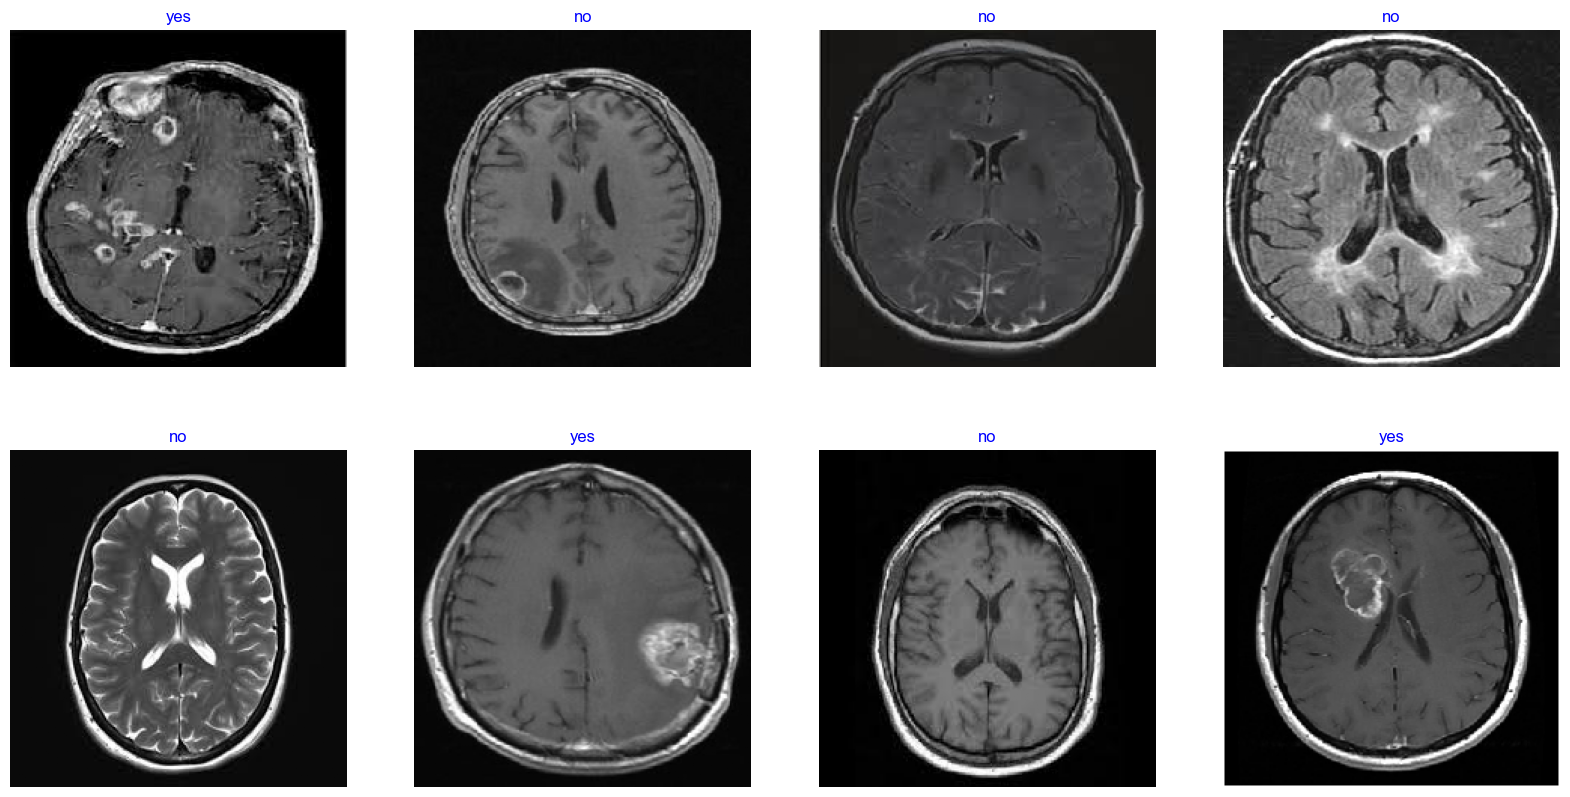

In [23]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [24]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

43941136/43941136 [==============================] - 8s 0us/step


In [25]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11183665 (42.66 MB)
Trainable params: 1109

In [26]:
history = model.fit(x= train_gen, epochs= 30, verbose= 1, validation_data= test_gen,validation_steps= None, shuffle= False)

Epoch 1/30
26/26 [==============================] - 144s 4s/step - loss: 8.1436 - accuracy: 0.7624 - val_loss: 8.9489 - val_accuracy: 0.7059
Epoch 2/30
26/26 [==============================] - 89s 3s/step - loss: 7.2426 - accuracy: 0.8218 - val_loss: 7.8624 - val_accuracy: 0.8431
Epoch 3/30
26/26 [==============================] - 89s 3s/step - loss: 6.6198 - accuracy: 0.8861 - val_loss: 6.8571 - val_accuracy: 0.8627
Epoch 4/30
26/26 [==============================] - 94s 4s/step - loss: 6.1975 - accuracy: 0.9010 - val_loss: 6.2255 - val_accuracy: 0.8431
Epoch 5/30
26/26 [==============================] - 91s 4s/step - loss: 5.7289 - accuracy: 0.9356 - val_loss: 5.6894 - val_accuracy: 0.9020
Epoch 6/30
26/26 [==============================] - 91s 4s/step - loss: 5.4262 - accuracy: 0.9406 - val_loss: 5.3656 - val_accuracy: 0.9020
Epoch 7/30
26/26 [==============================] - 89s 3s/step - loss: 5.2437 - accuracy: 0.9158 - val_loss: 5.1654 - val_accuracy: 0.8824
Epoch 8/30
26/26 [=

In [27]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 4s 577ms/step - loss: 2.3547 - accuracy: 0.9608
Train Loss:  2.2784547805786133
Train Accuracy:  1.0
--------------------
Test Loss:  2.3547253608703613
Test Accuracy:  0.9607843160629272


In [28]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

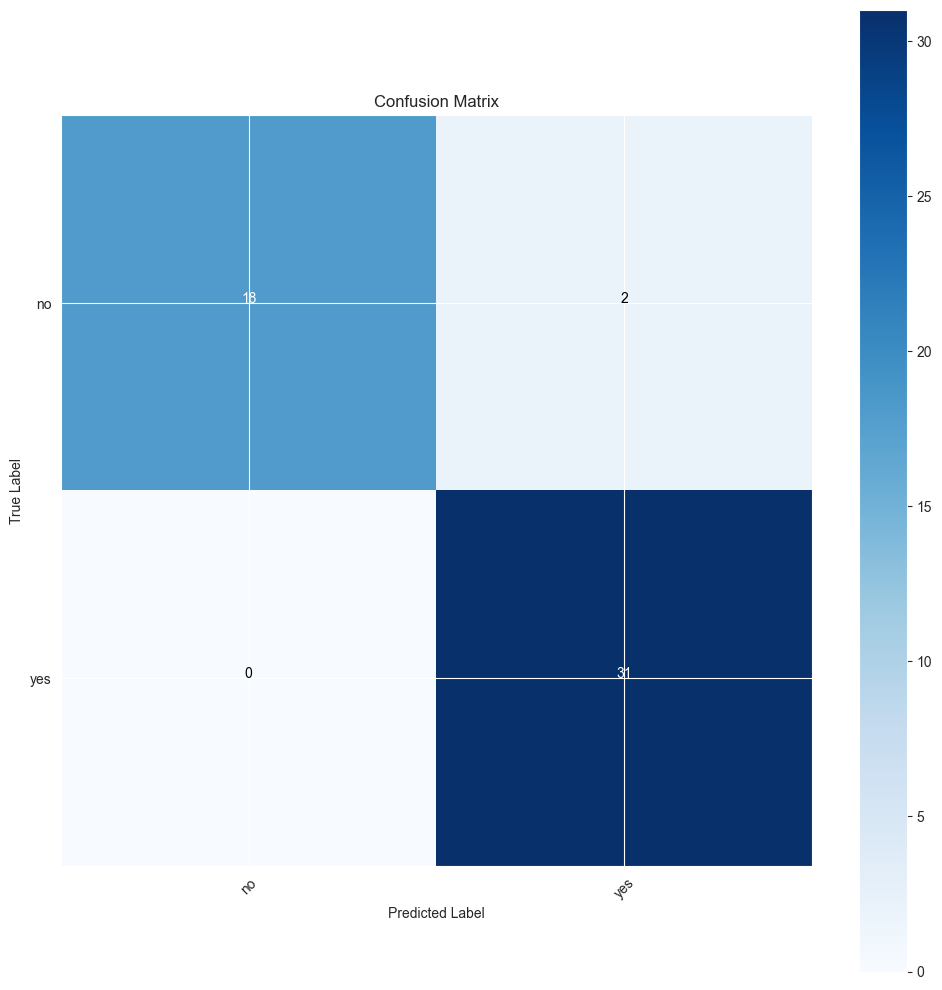

In [30]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [29]:
model.save("Model.h5")